<a href="https://colab.research.google.com/github/ShinKunKun/DAPPER-v0.8/blob/master/Primal_Dual_WGF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from scipy.sparse import dia_matrix, identity, bmat, csr_matrix,csc_matrix, block_diag, kron, identity
from scipy.sparse.linalg import eigs
from jax import vmap, jit, grad
import jax.numpy as jnp 

In [2]:
# Consider 1 dimensional Porus media equation
m = 2   # diffusion exponent
d = 1   # dimension     

In [3]:
# space config.
left_x  = -1
right_x = +1
N_x     = 100
Delta_x = (right_x-left_x)/(N_x+1)
Omega   = np.linspace(-1,1,N_x+1)

# time and internal time
t_0     = 1e-3
N_t     = 100
Delta_t = 1/N_t
tau     = 5e-4
n       = 10 # num. of steps
Inter   = np.linspace(0,1,N_t+1)
T       = t_0 + np.arange(n) * tau

# vector size
N = (N_x+1) * (N_t+1)

# constraint parameter
delta   = 1e-5
delta_3 = 1e-5 
eps     = 1e-5 # stopping criteria

# prox. parameter
lamda = 0.2
sigma = 0.1954
iter  = 10

In [4]:
# exact sol. (Barenblatt profiles)
def Exact(x,t,t_0,d,m):
  C     = np.power(3/16,1/3)
  alpha = d/(d*(m-1)+2)
  beta  = alpha/d
  k     = alpha*(m-1)/(2*m*d)
  pos   = C-k*np.sum(x**2)*np.power(t+t_0,-2*beta)
  return np.power(t+t_0,-alpha)*np.power(np.where(pos > 0, pos, 0),1/(m-1))

In [5]:
def internal_energy(rho):
  return jnp.power(rho,m)/(m-1)

In [6]:
def potential_energy(x):
  return 0
def interaction_energy(x,y):
  return 0

In [7]:
I=range(Omega.size)

In [8]:
def Energy(rho):
  V  = np.array([potential_energy(x) for x in Omega])
  UV = (Delta_x)**d*jnp.sum(internal_energy(rho)+V*rho)
  I  = range(Omega.size)
  # W  = 0.5*(Delta_x)**(2*d)*jnp.sum(np.array([interaction_energy(Omega[i],Omega[j])*rho[i]*rho[j] for i in I for j in I]))
  W  = 0
  return UV + W

In [9]:
rho_0 = np.array([Exact(x,0,t_0,d,m) for x in Omega])
print(rho_0)

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.09023788 0.92357121 1.69023788 2.39023788 3.02357121
 3.59023788 4.09023788 4.52357121 4.89023788 5.19023788 5.42357121
 5.59023788 5.69023788 5.72357121 5.69023788 5.59023788 5.42357121
 5.19023788 4.89023788 4.52357121 4.09023788 3.59023788 3.02357121
 2.39023788 1.69023788 0.92357121 0.09023788 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0

In [10]:
Energy(rho_0)

DeviceArray(9.066657, dtype=float32)

In [11]:
mv_0 = np.array([x for x in Omega])
print(mv_0)

[-1.   -0.98 -0.96 -0.94 -0.92 -0.9  -0.88 -0.86 -0.84 -0.82 -0.8  -0.78
 -0.76 -0.74 -0.72 -0.7  -0.68 -0.66 -0.64 -0.62 -0.6  -0.58 -0.56 -0.54
 -0.52 -0.5  -0.48 -0.46 -0.44 -0.42 -0.4  -0.38 -0.36 -0.34 -0.32 -0.3
 -0.28 -0.26 -0.24 -0.22 -0.2  -0.18 -0.16 -0.14 -0.12 -0.1  -0.08 -0.06
 -0.04 -0.02  0.    0.02  0.04  0.06  0.08  0.1   0.12  0.14  0.16  0.18
  0.2   0.22  0.24  0.26  0.28  0.3   0.32  0.34  0.36  0.38  0.4   0.42
  0.44  0.46  0.48  0.5   0.52  0.54  0.56  0.58  0.6   0.62  0.64  0.66
  0.68  0.7   0.72  0.74  0.76  0.78  0.8   0.82  0.84  0.86  0.88  0.9
  0.92  0.94  0.96  0.98  1.  ]


In [12]:
def Phi(rho,mv): # rho:numberm, m:vector 
  if rho > 0:
    return np.sum(mv**2)/rho
  elif rho == 0 and mv == np.zeros_like(mv):
    return 0
  else:
    return 1e+10

Phiv = np.vectorize(Phi)

def Kinetic_energy(rho,mv): # rho and m is ndarray(N_t*N_x)
  return np.sum(Phiv(rho,mv))*(Delta_x)**d*(Delta_t)  

In [13]:
Kinetic_energy(rho_0,mv_0)

146534653.4656978

In [14]:
rho0 = np.array([[Exact(x,t,t_0,d,m) for x in Omega] for t in Inter])
mv0  = np.array([[-x for x in Omega] for t in Inter])
u0   = np.concatenate([rho0.ravel(),mv0.ravel()])
print(u0)

[ 0.    0.    0.   ... -0.96 -0.98 -1.  ]


In [15]:
# prepare for proximal stepping
u_0 = np.block([rho_0,mv_0])
u_0.shape

(202,)

In [16]:
D_t1  = dia_matrix((np.array([np.block([0, np.ones(N_t)]), np.block([-np.ones(N_t),0])]),np.array([0,-1])),shape=(N_t+1,N_t+1))
D_t2  = dia_matrix((np.array([np.block([1, np.zeros(N_t)])]),np.array([0])),shape=(N_t+1,N_t+1))
I_x1  = dia_matrix((np.array([np.block([0, np.ones(N_x-1),0])]),np.array([0])),shape=(N_x+1,N_x+1))
A_rho1= kron(D_t1,I_x1)
A_rho2= kron(D_t2,identity(N_x+1)) # suspect the paper is wrong...
A_rho = A_rho1 + A_rho2

In [17]:
print(D_t2)
print(A_rho.toarray().shape)

  (0, 0)	1.0
  :	:
  (0, 0)	1.0
(10201, 10201)


In [18]:
data = np.array([-np.ones(N_x+1), np.ones(N_x+1)])
 
data[1][1] = 0
data[0][N_x-1] = 0
 
offsets = np.array([-1, 1])
B = dia_matrix((data, offsets), shape = (N_x+1, N_x+1))

D_x1  = (0.5*Delta_t/Delta_x)*B
D_x2  = dia_matrix((np.array([np.block([1, np.zeros(N_x-1),1])]),np.array([0])),shape=(N_x+1,N_x+1))
B_t1  = dia_matrix((np.array([np.block([0, np.ones(N_t)]), np.block([np.ones(N_t),0])]),np.array([0,-1])),shape=(N_t+1,N_t+1))
A_m1  = kron(B_t1,D_x1)
A_m2  = kron(identity(N_t+1),D_x2)
A_m   = A_m1 + A_m2

In [19]:
print(A_m.toarray().shape)

(10201, 10201)


In [20]:
S_rho = Delta_x*csr_matrix(np.ones((1,N_x+1)))

In [21]:
A_mass = kron(identity(N_t+1),S_rho)

In [22]:
print(A_mass.toarray())

[[0.01980198 0.01980198 0.01980198 ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.01980198 0.01980198 0.01980198]]


In [23]:
# A_1 = bmat([[A_rho1,A_m1],[None,None]]) 
# A_2 = bmat([[None,A_m2],[None,None]]) 
# A_3 = bmat([[None,None],[A_mass,None]])
# A_4 = bmat([[A_rho2,None],[None,None]]) 
A   = bmat([[A_rho, A_m],[A_mass, None]])
print(A.shape)

(10302, 20402)


In [24]:
A=csr_matrix(A)
value,vectior=eigs(A.dot(A.transpose()))
print(value[0].real)
sigma=0.9/(value[0].real*lamda)
print(sigma)

4.037872240989932
1.1144483360119317


In [25]:
u_0.shape

(202,)

In [26]:
# matrix-vector product
A.dot(u0)

array([1.        , 0.        , 0.        , ..., 1.09429312, 1.09098784,
       1.08772287])

In [53]:
def b_4(rho_0):
  init = np.zeros(N+N_t+1)
  init[0:N_x+1] = rho_0 # suspect the paper is wrong...
  return init

def b_3(rho_0):
  return np.concatenate([np.zeros(N),1*np.ones(N_t+1)]) # 1* should be sum(rho_0) 

In [28]:
b_4(rho_0).shape

(10302,)

In [30]:
b_3(rho_0).shape

(10302,)

In [31]:
rho0.shape

(101, 101)

In [32]:
a,b=np.split(u0,2)
a

array([0.        , 0.        , 0.        , ..., 0.49544319, 0.49221308,
       0.48891638])

In [33]:
u0.reshape([2,N]).T

array([[ 0.        ,  1.        ],
       [ 0.        ,  0.98      ],
       [ 0.        ,  0.96      ],
       ...,
       [ 0.49544319, -0.96      ],
       [ 0.49221308, -0.98      ],
       [ 0.48891638, -1.        ]])

In [34]:
def cubic_equation(a,b,c,d):
    p = -b**2/(9.0*a**2) + c/(3.0*a)
    q = b**3/(27.0*a**3) - b*c/(6.0*a**2) + d/(2.0*a)
    t = complex(q**2+p**3)
    w =(-1.0 +1j*3.0**0.5)/2.0

    u = [0,0,0]
    u[0] = (-q +t**0.5)**(1.0/3.0)
    u[1] = u[0] * w
    u[2] = u[0] * w**2
    v = [0,0,0]
    v[0] = (-q -t**0.5)**(1.0/3.0)
    v[1] = v[0] * w
    v[2] = v[0] * w**2

    x_list = []
    for i in range(3):
      for j in range(3):
        if abs(u[i]*v[j] + p) <1e-5:
            x = u[i] + v[j]
            if abs(x.imag) < 1e-10:
                x = x.real - b/(3.0*a)
                x_list.append(x)
    return max(x_list)

print(cubic_equation(1,-2,-11,12))

3.9999999999999996


In [54]:
# proximal operators
def Proj_Ball(x,delta,rho_0):
  b = b_4(rho_0) + b_3(rho_0)
  m = np.max([1,np.linalg.norm(x-b)/delta])
  return (x-b)/m + b

def Prox_sigmai(x,sigma,delta,rho_0):
  return x - sigma*Proj_Ball(x/sigma,delta,rho_0)

def Prox_varphi(rhom,lamda):
  rho = rhom[0]
  mv  = rhom[1]
  if rho > 0:
    rho_ast = cubic_equation(1,2*lamda-rho,lamda*lamda-2*rho*lamda,-rho*lamda*lamda-0.5*lamda*mv**2)
    m_ast   = rho_ast*mv/(rho_ast+lamda)
    return np.array([rho_ast,m_ast])
  else:
    return np.zeros_like(rhom)
# Prox_varphi = np.vectorize(Prox_varphi)

def Prox_Phi(u,lamda):
  return np.apply_along_axis(Prox_varphi, 0, u.reshape([2,N]), lamda=lamda).reshape([2*N])
  # return Prox_varphi(u.reshape([2,N]).T).T.reshape([2*N])


In [36]:
print(u0.shape)
Prox_Phi(u0,lamda).shape

(20402,)


(20402,)

In [37]:
rho_zero = np.zeros_like(rho0)
rho_zero[0] = rho_0
print(rho_zero[0])
print(Energy(rho_0))
sum(np.apply_along_axis(Energy,1,rho_zero))

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.09023788 0.92357121 1.69023788 2.39023788 3.02357121
 3.59023788 4.09023788 4.52357121 4.89023788 5.19023788 5.42357121
 5.59023788 5.69023788 5.72357121 5.69023788 5.59023788 5.42357121
 5.19023788 4.89023788 4.52357121 4.09023788 3.59023788 3.02357121
 2.39023788 1.69023788 0.92357121 0.09023788 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0

9.066657066345215

In [38]:
def E(u):
  return Energy(u.reshape([2,N_t+1,N_x+1])[0][-1])

grad_E = grad(E)

In [39]:
def varPhi(u):
  rho1,mv1 = np.split(u,2)
  rho2     = rho1.reshape([N_t+1,N_x+1])
  mv2      = mv1.reshape([N_t+1,N_x+1])
  return Kinetic_energy(rho2,mv2)

In [40]:
varPhi(u0)

348514852.67514724

In [41]:
grad_E(u0)

DeviceArray([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [55]:
# Primal-Dual algorithm
def Primal_Dual(u,phi,iter,lamda,sigma,tau,delta,eps,rho_0):
  u_tmp   = u
  gradE   = 2*tau*lamda*grad_E(u_tmp)
  u_new   = u
  u_bar   = u
  phi_tmp = phi
  phi_new = phi
  # phi_new = np.zeros_like(phi)
  l     = 0
  while l < iter:
    print(l)
    phi_new = Prox_sigmai(phi_tmp+sigma*A.dot(u_bar),sigma,delta,rho_0)
    u_new   = Prox_Phi(u_tmp-gradE-lamda*A.transpose().dot(phi_new),lamda)
    u_bar   = 2*u_new-u_tmp+gradE-2*tau*lamda*grad_E(u_new)
    if abs(1-E(u_tmp)/E(u_new)) < eps and np.linalg.norm(u_new-u_tmp)/np.linalg.norm(u_new) < eps and np.linalg.norm(phi_new-phi_tmp)/np.linalg.norm(phi_new) < eps:
      break
    u_tmp   = u_new
    phi_tmp = phi_new
    gradE   =  2*tau*lamda*grad_E(u_tmp)
    print(varPhi(u_new)+2*tau*E(u_new))
    l      += 1
  
  return [u_new,phi_new]

In [43]:
iter = 100
delta=1e-4

In [44]:
rho0 = np.array([[Exact(x,t,t_0,d,m) for x in Omega] for t in Inter])
mv0  = np.array([[0 for x in Omega] for t in Inter])
u0   = np.concatenate([rho0.ravel(),mv0.ravel()])

In [45]:
phi0 = np.zeros(N+N_t+1)
u1,phi1=Primal_Dual(u0,phi0,iter,lamda,sigma,tau,delta,eps,rho_0)

0
0.0019364506
1
0.006871743
2
0.01974877
3
0.04676581
4
0.09559263
5
0.17495523
6
0.2942195
7
0.46295875
8
0.6904899
9
0.9853948
10
1.3550578
11
1.8052467
12
2.3397563
13
2.960121
14
3.6654158
15
4.4521465
16
5.3142247
17
6.2430468
18
7.227655
19
8.254984
20
9.310191
21
10.377043
22
11.438358
23
12.476491
24
13.473843
25
14.413354
26
15.279016
27
16.056334
28
16.732748
29
17.297995
30
17.744396
31
18.067085
32
18.264122
33
18.336533
34
18.288265
35
18.126053
36
17.859228
37
17.499512
38
17.024757
39
16.518251
40
15.964792
41
15.110382
42
14.479926
43
13.864719
44
13.321732
45
12.703598
46
12.190785
47
11.711876
48
11.274347
49
10.621594
50
10.350428
51
10.230758
52
10.1580305
53
10.143303
54
10.152286
55
10.149195
56
10.3567
57
10.591785
58
10.866582
59
11.160661
60
11.476183
61
11.925633
62
12.126505
63
12.30988
64
12.513622
65
12.855581
66
13.187994
67
13.531945
68
13.366034
69
13.008468
70
11.573907
71
12.029364
72
12.49673
73
12.2889805
74
12.688132
75
13.105381
76
13.739038
77
14

In [46]:
u0.reshape([2,N_t+1,N_x+1])[0][0]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.09023788, 0.92357121, 1.69023788,
       2.39023788, 3.02357121, 3.59023788, 4.09023788, 4.52357121,
       4.89023788, 5.19023788, 5.42357121, 5.59023788, 5.69023788,
       5.72357121, 5.69023788, 5.59023788, 5.42357121, 5.19023788,
       4.89023788, 4.52357121, 4.09023788, 3.59023788, 3.02357121,
       2.39023788, 1.69023788, 0.92357121, 0.09023788, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [47]:
u1.reshape([2,N_t+1,N_x+1])[0][-1]

array([81.59365 , 81.6101  , 81.61879 , 81.61693 , 81.62792 , 81.6238  ,
       81.63531 , 81.630684, 81.64228 , 81.63751 , 81.64907 , 81.64429 ,
       81.65567 , 81.65098 , 81.66197 , 81.657486, 81.66796 , 81.66385 ,
       81.67358 , 81.66998 , 81.67879 , 81.67588 , 81.68361 , 81.68151 ,
       81.688034, 81.68685 , 81.69213 , 81.69185 , 81.69593 , 81.696526,
       81.69949 , 81.70082 , 81.702866, 81.70474 , 81.70608 , 81.70829 ,
       81.709114, 81.711426, 81.71196 , 81.714165, 81.71455 , 81.71649 ,
       81.716805, 81.718376, 81.718636, 81.7198  , 81.72001 , 81.72078 ,
       81.720825, 81.72126 , 81.72109 , 81.72126 , 81.720825, 81.72078 ,
       81.72001 , 81.7198  , 81.718636, 81.718376, 81.716805, 81.71649 ,
       81.71455 , 81.714165, 81.71196 , 81.711426, 81.709114, 81.70829 ,
       81.70608 , 81.70474 , 81.702866, 81.70082 , 81.69949 , 81.696526,
       81.69593 , 81.69185 , 81.69213 , 81.68685 , 81.688034, 81.68151 ,
       81.68361 , 81.67588 , 81.67879 , 81.66998 , 

In [81]:
# JKO sequence
def JKO(rho_0,lamda,sigma,tau,n,delta,iter,eps):
  # Initialize
  rho        = np.zeros((n+1,N_x+1))
  rho[0]     = rho_0
  u          = np.zeros(2*N)
  u[0:N_x+1] = rho_0
  phi        = np.zeros(N+N_t+1)
  u_ast      = np.zeros_like(u)
  phi_ast    = np.zeros_like(phi)
  for k in range(n):
    u_ast, phi_ast = Primal_Dual(u,phi,iter,lamda,sigma,tau,delta,eps,u[0:N_x+1]) # Don't forget to updating rho_0
    rho[k+1]       = u_ast.reshape([2,N_t+1,N_x+1])[0][-1]
    phi            = phi_ast
    u              = u_ast - np.kron(np.concatenate([np.ones(N_t+1),np.zeros(N_t+1)]),rho[k]) + np.kron(np.concatenate([np.zeros(N_t+1),np.ones(N_t+1)]),rho[k+1])
    u              = 0.5*(u+abs(u))
  
  return rho

In [49]:
np.kron(np.concatenate([np.ones(N_t+1),np.zeros(N_t+1)]),rho_0).shape

(20402,)

In [82]:
# space config.
left_x  = -1
right_x = +1
N_x     = 100
Delta_x = (right_x-left_x)/(N_x+1)
Omega   = np.linspace(-1,1,N_x+1)

# time and internal time
t_0     = 1e-3
N_t     = 100
Delta_t = 1/N_t
tau     = 5e-5
n       = 10 # num. of steps
Inter   = np.linspace(0,1,N_t+1)
T       = t_0 + np.arange(n) * tau

# vector size
N = (N_x+1) * (N_t+1)

# constraint parameter
delta   = 1e-5
delta_3 = 1e-5 
eps     = 1e-5 # stopping criteria

# prox. parameter
lamda = 1
sigma = 0.1954
iter  = 100

rho_0 = np.array([Exact(x,0,t_0,d,m) for x in Omega])
A=csr_matrix(A)
value,vectior=eigs(A.dot(A.transpose()))
print(value[0].real)
sigma=0.9/(value[0].real*lamda)
print(sigma)

4.037872240989943
0.2228896672023858


In [83]:
rho=JKO(rho_0,lamda,sigma,tau,n,delta,iter,eps)

0
3.8960697e-09
1
3.4653066e-08
2
1.3658261e-07
3
3.7274089e-07
4
8.215267e-07
5
1.5726226e-06
6
2.7224446e-06
7
4.3692785e-06
8
6.6082966e-06
9
9.526635e-06
10
1.31987435e-05
11
1.7682149e-05
12
2.301381e-05
13
2.9207225e-05
14
3.625032e-05
15
4.410429e-05
16
5.2703355e-05
17
6.195552e-05
18
7.174424e-05
19
8.193097e-05
20
9.235852e-05
21
0.00010285505
22
0.00011323864
23
0.00012332221
24
0.00013291882
25
0.00014184654
26
0.00014993391
27
0.00015702448
28
0.0001629812
29
0.00016769019
30
0.00017106369
31
0.00017304248
32
0.00017359704
33
0.00017272825
34
0.0001704669
35
0.0001668724
36
0.00016203082
37
0.00015605199
38
0.00014906604
39
0.00014121959
40
0.00013267128
41
0.0001235874
42
0.00011413716
43
0.00010448826
44
9.480258e-05
45
8.5232175e-05
46
7.5915865e-05
47
6.697626e-05
48
5.8517628e-05
49
5.0624192e-05
50
4.3359407e-05
51
3.6765756e-05
52
3.0865405e-05
53
2.5661426e-05
54
2.113962e-05
55
1.7270844e-05
56
1.4013733e-05
57
1.1317685e-05
58
9.126027e-06
59
7.379196e-06
60
6.01

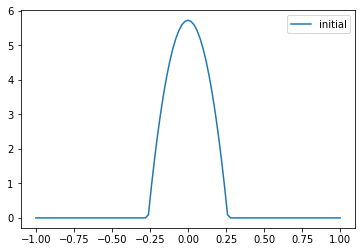

In [84]:
# visualize
import matplotlib.pyplot as plt
plt.plot(Omega,rho[0],label='initial')
plt.legend()
plt.show()

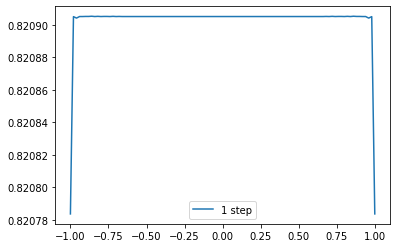

In [85]:
plt.plot(Omega,rho[1],label='1 step')
plt.legend()
plt.show()

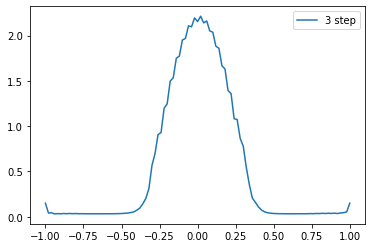

In [93]:
plt.plot(Omega,rho[3],label='3 step')
plt.legend()
plt.show()

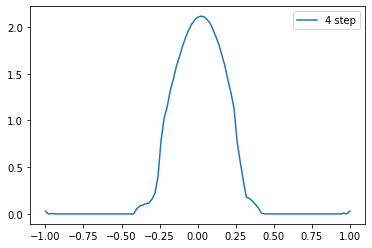

In [92]:
plt.plot(Omega,rho[4],label='4 step')
plt.legend()
plt.show()

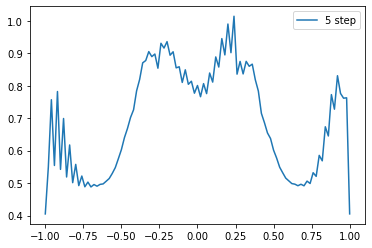

In [86]:
plt.plot(Omega,rho[5],label='5 step')
plt.legend()
plt.show()

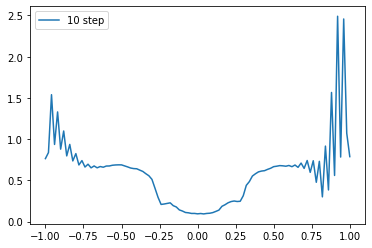

In [87]:
plt.plot(Omega,rho[10],label='10 step')
plt.legend()
plt.show()